In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import (
    CloughTocher2DInterpolator,
    LinearNDInterpolator,
    NearestNDInterpolator,
)
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy.spatial import cKDTree
import numpy as np
from pyproj import CRS, Transformer

In [2]:
# import xarray as xr
# import numpy as np
# import intake

# eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

# model = 'ifs-fesom2-sr'
# expid = 'hist-1950'  # 'highres-future-ssp245', 'hist-1950', 'eerie-control-1950', 'eerie-spinup-1950'
# version = 'v20240304'    #
# realm='atmos'  # 'ocean' , 'land', 'atmos'
# gridspec = 'native' # 'native', 'gr025'

# cat_data=eerie_cat['dkrz.disk.model-output'][model][expid][version][realm][gridspec]
# print(list(cat_data))

# # ds = cat_data['2D_daily_avg'].to_dask()
# # ds

In [3]:
# ds = cat_data['2D_daily_avg'].to_dask()
# ds

In [9]:
import xarray as xr

ds = xr.open_dataset("/scratch/awicm3/TCo1279-DART-1950C/outdata/oifs/atm_reduced_3h_2t_3h_196912-196912.nc")
print(ds)

lon = ds['lon'].values
lat = ds['lat'].values

# print("lon:", lon)
# print("lat:", lat)


<xarray.Dataset> Size: 7GB
Dimensions:              (cell: 6599680, nvertex: 4, time_counter: 248,
                          axis_nbounds: 2)
Coordinates:
    lat                  (cell) float32 26MB ...
    lon                  (cell) float32 26MB ...
    time_instant         (time_counter) datetime64[ns] 2kB ...
  * time_counter         (time_counter) datetime64[ns] 2kB 1969-12-01T03:00:0...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables:
    bounds_lon           (cell, nvertex) float32 106MB ...
    bounds_lat           (cell, nvertex) float32 106MB ...
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] 4kB ...
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 4kB ...
    2t                   (time_counter, cell) float32 7GB ...
Attributes:
    name:         atm_reduced_3h_2t_3h
    description:  ECE4/OIFS 3hourly surface fields
    title:        ECE4/OIFS 3hourly surface fields
    Conventions:  CF-1.6
    timeStamp: 

In [10]:
mask = xr.open_dataset('/proj/sunseon/PROJ/AWI-CM3/Hackathon_2025/data/tco1279.coastal.region.theta.nc')

In [11]:
mask

<xarray.Dataset> Size: 158MB
Dimensions:  (lat: 2560, lon: 5136)
Coordinates:
  * lat      (lat) float64 20kB -89.97 -89.89 -89.82 ... 89.82 89.89 89.97
  * lon      (lon) float64 41kB 0.0 0.07009 0.1402 0.2103 ... 359.8 359.9 359.9
Data variables:
    coastal  (lat, lon) float64 105MB ...
    theta    (lat, lon) float32 53MB ...

In [12]:
import matplotlib.pylab as plt

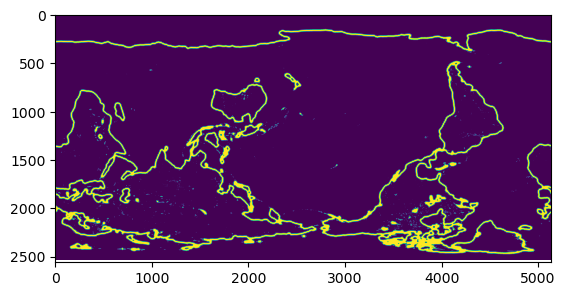

In [13]:
plt.imshow(mask.coastal)

In [14]:
# lon = ds.lon.values
# lat = ds.lat.values

In [15]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)), balanced_tree=False, compact_nodes=False)
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds


In [16]:
mask_lon = mask.lon.values
mask_lat = mask.lat.values
mask_lon2, mask_lat2 = np.meshgrid(mask_lon, mask_lat)

In [17]:
coast_lat = mask_lat2.ravel()[mask.coastal.values.ravel()==1]
coast_lon = mask_lon2.ravel()[mask.coastal.values.ravel()==1]

In [18]:
from scipy.spatial import cKDTree

In [19]:
distances, inds = create_indexes_and_distances(lon, lat, coast_lon, coast_lat, k=1, workers=10)

In [21]:
data_sample = ds['2t'][0,:]
# data_sample2 = data['2t'][1106,:]

radius_of_influence=10000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
# data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

In [22]:
data_interpolated.shape

(931268,)

In [23]:
coast_lon.shape

(931268,)

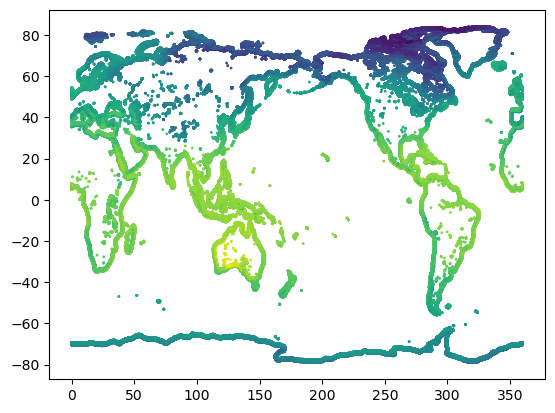

In [24]:
plt.scatter(coast_lon, coast_lat, s=1, c=data_interpolated)

In [25]:
mask.coastal.values.ravel()

array([nan, nan, nan, ..., nan, nan, nan])